In [1]:
#DATA CHALLENGE FINAL PROJECT

# Importing libraries and exploring DF

In [2]:
import networkx as nx
import pandas as pd
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import os


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
directory = "Data_metrics"
file_name = "df1.csv"
df_1 = pd.read_csv(os.path.join(directory, file_name))

In [5]:
df = pd.read_csv(os.path.join(directory,'df.csv'))
df.head()

,title,authors,year,venue,index,citations,abstract,cleaned_abstract,dominant_topic
0,Automated Deduction in Geometry: 5th Internati...,"Hoon Hong,Dongming Wang",2006,NaN,0,NaN,NaN,NaN,0
1,A+ Certification Core Hardware (Text & Lab Man...,Charles J. Brooks,2003,NaN,1,NaN,NaN,NaN,0
2,Performance engineering in industry: current p...,"Ahmed E. Hassan,Parminder Flora",2007,Proceedings of the 6th international workshop ...,2,NaN,This panel session discusses performance engin...,panel session discusses performance engineerin...,3
3,"Dude, You Can Do It! How to Build a Sweeet PC","Darrel Creacy,Carlito Vicencio",2005,NaN,3,NaN,Whether you're frustrated with current PC offe...,whether frustrated current pc offering inflate...,2
4,What Every Programmer Needs to Know about Secu...,"Neil Daswani,Anita Kesavan",2006,NaN,4,NaN,NaN,NaN,0


In [6]:
# Check if indices match
print("Do indices match?", df.index.equals(df_1.index))


Do indices match? True


In [7]:
# Merge df with df_1 using the index
df['citations'] = df_1['citations']



In [8]:
df['citations'] = df['citations'].apply(
    lambda x: list(map(int, x.split(';'))) if isinstance(x, str) and x.strip() else []
)


In [9]:
df['citations'].head(10)

0          []
1          []
2          []
3          []
4          []
5    [436405]
6          []
7          []
8          []
9          []
Name: citations, dtype: object

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629814 entries, 0 to 629813
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   title             629814 non-null  object
 1   authors           603898 non-null  object
 2   year              629814 non-null  int64 
 3   venue             531220 non-null  object
 4   index             629814 non-null  int64 
 5   citations         629814 non-null  object
 6   abstract          281080 non-null  object
 7   cleaned_abstract  281051 non-null  object
 8   dominant_topic    629814 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 43.2+ MB


## Create the Graph from DataFrame

In [11]:
# Create a directed graph
G = nx.DiGraph()

# Add edges from citations
for paper_id, row in df.iterrows():
    if 'citations' in df.columns and isinstance(row['citations'], list):  # Ensure citations exist
        for cited_paper in row['citations']:
            if not pd.isna(cited_paper):
                G.add_edge(paper_id, cited_paper)

# Debug: Check the graph
print("Original Graph:")
print("Number of nodes:", len(G.nodes()))
print("Number of edges:", len(G.edges()))


Original Graph:
Number of nodes: 217335
Number of edges: 632751


##  Split Nodes into Train and Test

In [12]:
# Shuffle and split nodes
all_nodes = list(G.nodes())
random.seed(42)
random.shuffle(all_nodes)

split_index = int(0.8 * len(all_nodes))
train_nodes = set(all_nodes[:split_index])
test_nodes = set(all_nodes[split_index:])

# Debug: Check node counts
print("Train nodes count:", len(train_nodes))
print("Test nodes count:", len(test_nodes))


Train nodes count: 173868
Test nodes count: 43467


## Split Edges into Train and Test

In [13]:
# Filter edges for train and test graphs
train_edges = [(u, v) for u, v in G.edges() if u in train_nodes and v in train_nodes]
test_edges = [(u, v) for u, v in G.edges() if u in test_nodes and v in test_nodes]

# Create train and test graphs
G_train = nx.DiGraph()
G_train.add_edges_from(train_edges)

G_test = nx.DiGraph()
G_test.add_edges_from(test_edges)

# Debug: Check train and test graphs
print("Train Graph:")
print("Nodes:", len(G_train.nodes()), "Edges:", len(G_train.edges()))
print("Test Graph:")
print("Nodes:", len(G_test.nodes()), "Edges:", len(G_test.edges()))


Train Graph:
Nodes: 162097 Edges: 404969
Test Graph:
Nodes: 22670 Edges: 25400


## Generate Negative Samples

In [14]:
# Function to generate negative samples
def generate_negative_samples(G, num_samples):
    nodes = list(G.nodes())
    negative_samples = set()

    while len(negative_samples) < num_samples:
        u, v = random.choice(nodes), random.choice(nodes)
        if u != v and not G.has_edge(u, v):
            negative_samples.add((u, v))
    return list(negative_samples)

# Generate negative samples
train_negative_samples = generate_negative_samples(G_train, len(train_edges))
test_negative_samples = generate_negative_samples(G_test, len(test_edges))

# Combine positive and negative samples
train_samples_combined = train_edges + train_negative_samples
test_samples_combined = test_edges + test_negative_samples

# Assign labels
train_labels = [1] * len(train_edges) + [0] * len(train_negative_samples)
test_labels = [1] * len(test_edges) + [0] * len(test_negative_samples)


## Create DataFrames for Train and Test


In [15]:
# Create labeled DataFrames
train_df_combined = pd.DataFrame(train_samples_combined, columns=['paper_A', 'paper_B'])
train_df_combined['label'] = train_labels

test_df_combined = pd.DataFrame(test_samples_combined, columns=['paper_A', 'paper_B'])
test_df_combined['label'] = test_labels


## Add Features

In [16]:
# Example: Add shared keywords
vectorizer = CountVectorizer(stop_words='english', binary=True)
abstract_matrix = vectorizer.fit_transform(df['abstract'].fillna(''))

def compute_shared_keywords(paper_A, paper_B, matrix):
    set_A = set(matrix[paper_A].nonzero()[1])
    set_B = set(matrix[paper_B].nonzero()[1])
    return len(set_A.intersection(set_B))

train_df_combined['shared_keywords'] = [
    compute_shared_keywords(row['paper_A'], row['paper_B'], abstract_matrix)
    for _, row in train_df_combined.iterrows()
]

test_df_combined['shared_keywords'] = [
    compute_shared_keywords(row['paper_A'], row['paper_B'], abstract_matrix)
    for _, row in test_df_combined.iterrows()
]

### Map Dominant Topics

The primary topic assigned to paper_A and paper_B based on topic modeling (e.g., LDA).

In [17]:
# Map dominant topics from df to train_df_combined and test_df_combined
train_df_combined['dominant_topic_A'] = train_df_combined['paper_A'].map(df['dominant_topic'])
train_df_combined['dominant_topic_B'] = train_df_combined['paper_B'].map(df['dominant_topic'])

test_df_combined['dominant_topic_A'] = test_df_combined['paper_A'].map(df['dominant_topic'])
test_df_combined['dominant_topic_B'] = test_df_combined['paper_B'].map(df['dominant_topic'])

# Verify the updated DataFrames
print("Train DataFrame with Dominant Topics:")
print(train_df_combined[['paper_A', 'paper_B', 'dominant_topic_A', 'dominant_topic_B']].head())

print("\nTest DataFrame with Dominant Topics:")
print(test_df_combined[['paper_A', 'paper_B', 'dominant_topic_A', 'dominant_topic_B']].head())


Train DataFrame with Dominant Topics:
   paper_A  paper_B  dominant_topic_A  dominant_topic_B
0        5   436405                 1                 1
1   436405    94584                 1                 0
2   436405   282290                 1                 0
3   436405   564235                 1                 0
4   436405   594837                 1                 0

Test DataFrame with Dominant Topics:
   paper_A  paper_B  dominant_topic_A  dominant_topic_B
0       17   294124                 0                 0
1   378077    74805                 0                 0
2      225   120985                 0                 0
3   120985   280345                 0                 0
4   120985   441542                 0                 0


### Temporal influence
Helps identify temporal relationships (e.g., newer papers citing older ones).

In [18]:
# Map publication years for train_df_combined
train_df_combined['year_A'] = train_df_combined['paper_A'].map(df['year'])
train_df_combined['year_B'] = train_df_combined['paper_B'].map(df['year'])

# Map publication years for test_df_combined
test_df_combined['year_A'] = test_df_combined['paper_A'].map(df['year'])
test_df_combined['year_B'] = test_df_combined['paper_B'].map(df['year'])

# Add binary feature for temporal influence
train_df_combined['temporal_influence'] = (train_df_combined['year_A'] < train_df_combined['year_B']).astype(int)
test_df_combined['temporal_influence'] = (test_df_combined['year_A'] < test_df_combined['year_B']).astype(int)


### Shared venue
Binary feature indicating whether paper_A and paper_B were published in the same venue.

In [19]:
# Map venues for papers
train_df_combined['venue_A'] = train_df_combined['paper_A'].map(df['venue'])
train_df_combined['venue_B'] = train_df_combined['paper_B'].map(df['venue'])

test_df_combined['venue_A'] = test_df_combined['paper_A'].map(df['venue'])
test_df_combined['venue_B'] = test_df_combined['paper_B'].map(df['venue'])

# Add binary feature for shared venue
train_df_combined['shared_venue'] = (train_df_combined['venue_A'] == train_df_combined['venue_B']).astype(int)
test_df_combined['shared_venue'] = (test_df_combined['venue_A'] == test_df_combined['venue_B']).astype(int)


### The degree centrality

The degree centrality of paper_A and paper_B in the graph, representing how connected each paper is.

In [20]:
# Compute degree centrality for G_train and G_test
degree_centrality_train = nx.degree_centrality(G_train)
degree_centrality_test = nx.degree_centrality(G_test)

# Map degree centrality for train_df_combined
train_df_combined['degree_centrality_A'] = train_df_combined['paper_A'].map(degree_centrality_train)
train_df_combined['degree_centrality_B'] = train_df_combined['paper_B'].map(degree_centrality_train)

# Map degree centrality for test_df_combined
test_df_combined['degree_centrality_A'] = test_df_combined['paper_A'].map(degree_centrality_test)
test_df_combined['degree_centrality_B'] = test_df_combined['paper_B'].map(degree_centrality_test)

# Compute product of degree centralities
train_df_combined['degree_centrality_product'] = train_df_combined['degree_centrality_A'] * train_df_combined['degree_centrality_B']
test_df_combined['degree_centrality_product'] = test_df_combined['degree_centrality_A'] * test_df_combined['degree_centrality_B']


### Topic same
feature that checks whether dominant_topic_A and dominant_topic_B are the same,

In [21]:
# Add a binary feature indicating if dominant_topic_A is the same as dominant_topic_B
train_df_combined['same_dominant_topic'] = (
    train_df_combined['dominant_topic_A'] == train_df_combined['dominant_topic_B']
).astype(int)

test_df_combined['same_dominant_topic'] = (
    test_df_combined['dominant_topic_A'] == test_df_combined['dominant_topic_B']
).astype(int)

# Verify the new feature
print("Train DataFrame with 'same_dominant_topic':")
print(train_df_combined[['dominant_topic_A', 'dominant_topic_B', 'same_dominant_topic']].head())

print("\nTest DataFrame with 'same_dominant_topic':")
print(test_df_combined[['dominant_topic_A', 'dominant_topic_B', 'same_dominant_topic']].head())


Train DataFrame with 'same_dominant_topic':
   dominant_topic_A  dominant_topic_B  same_dominant_topic
0                 1                 1                    1
1                 1                 0                    0
2                 1                 0                    0
3                 1                 0                    0
4                 1                 0                    0

Test DataFrame with 'same_dominant_topic':
   dominant_topic_A  dominant_topic_B  same_dominant_topic
0                 0                 0                    1
1                 0                 0                    1
2                 0                 0                    1
3                 0                 0                    1
4                 0                 0                    1


### Author collaboration_history

Binary feature indicating whether any authors of paper_A have collaborated with authors of paper_B.

In [22]:
# Preprocess authors column
df['authors'] = df['authors'].fillna('').apply(lambda x: x.split(',') if x else [])

# Debug: Check the processed authors column
print("Sample processed authors column:")
print(df['authors'].head())

# Map authors for train_df_combined
train_df_combined['authors_A'] = train_df_combined['paper_A'].map(df['authors'])
train_df_combined['authors_B'] = train_df_combined['paper_B'].map(df['authors'])

# Map authors for test_df_combined
test_df_combined['authors_A'] = test_df_combined['paper_A'].map(df['authors'])
test_df_combined['authors_B'] = test_df_combined['paper_B'].map(df['authors'])

# Build the collaboration graph
collaboration_graph = nx.Graph()

for authors in df['authors']:
    if authors:  # Skip empty author lists
        collaboration_graph.add_edges_from([(a1, a2) for a1 in authors for a2 in authors if a1 != a2])

# Debug: Check the collaboration graph
print("Collaboration Graph:")
print("Number of nodes:", collaboration_graph.number_of_nodes())
print("Number of edges:", collaboration_graph.number_of_edges())




Sample processed authors column:
0            [Hoon Hong, Dongming Wang]
1                   [Charles J. Brooks]
2    [Ahmed E. Hassan, Parminder Flora]
3     [Darrel Creacy, Carlito Vicencio]
4         [Neil Daswani, Anita Kesavan]
Name: authors, dtype: object
Collaboration Graph:
Number of nodes: 505016
Number of edges: 1137011


In [23]:
# Function to check collaboration history
def check_collaboration(authors_A, authors_B):
    if not authors_A or not authors_B:  # Handle empty author lists
        return 0
    for author_A in authors_A:
        for author_B in authors_B:
            if collaboration_graph.has_edge(author_A, author_B):
                return 1
    return 0

# Compute collaboration history for train_df_combined
train_df_combined['collaboration_history'] = [
    check_collaboration(authors_A, authors_B)
    for authors_A, authors_B in zip(train_df_combined['authors_A'], train_df_combined['authors_B'])
]

# Compute collaboration history for test_df_combined
test_df_combined['collaboration_history'] = [
    check_collaboration(authors_A, authors_B)
    for authors_A, authors_B in zip(test_df_combined['authors_A'], test_df_combined['authors_B'])
]


In [24]:
# Compute PageRank for G_train and G_test
pagerank_train = nx.pagerank(G_train)
pagerank_test = nx.pagerank(G_test)

# Map PageRank scores for train_df_combined
train_df_combined['pagerank_A'] = train_df_combined['paper_A'].map(pagerank_train)
train_df_combined['pagerank_B'] = train_df_combined['paper_B'].map(pagerank_train)
train_df_combined['pagerank_sum'] = train_df_combined['pagerank_A'] + train_df_combined['pagerank_B']

# Map PageRank scores for test_df_combined
test_df_combined['pagerank_A'] = test_df_combined['paper_A'].map(pagerank_test)
test_df_combined['pagerank_B'] = test_df_combined['paper_B'].map(pagerank_test)
test_df_combined['pagerank_sum'] = test_df_combined['pagerank_A'] + test_df_combined['pagerank_B']

# Verify the new feature
print("Train DataFrame with 'pagerank_sum':")
print(train_df_combined[['paper_A', 'paper_B', 'pagerank_A', 'pagerank_B', 'pagerank_sum']].head())

print("\nTest DataFrame with 'pagerank_sum':")
print(test_df_combined[['paper_A', 'paper_B', 'pagerank_A', 'pagerank_B', 'pagerank_sum']].head())


Train DataFrame with 'pagerank_sum':
   paper_A  paper_B  pagerank_A  pagerank_B  pagerank_sum
0        5   436405    0.000003    0.000012      0.000016
1   436405    94584    0.000012    0.000110      0.000123
2   436405   282290    0.000012    0.000007      0.000020
3   436405   564235    0.000012    0.000009      0.000021
4   436405   594837    0.000012    0.000034      0.000047

Test DataFrame with 'pagerank_sum':
   paper_A  paper_B  pagerank_A  pagerank_B  pagerank_sum
0       17   294124    0.000026    0.000089      0.000115
1   378077    74805    0.000047    0.000077      0.000124
2      225   120985    0.000026    0.000156      0.000182
3   120985   280345    0.000156    0.000243      0.000399
4   120985   441542    0.000156    0.000186      0.000342


In [25]:
# Shuffle the training and testing data
train_df_combined = train_df_combined.sample(frac=1, random_state=42).reset_index(drop=True)
test_df_combined = test_df_combined.sample(frac=1, random_state=42).reset_index(drop=True)


In [26]:
train_df_combined.columns

Index(['paper_A', 'paper_B', 'label', 'shared_keywords', 'dominant_topic_A',
       'dominant_topic_B', 'year_A', 'year_B', 'temporal_influence', 'venue_A',
       'venue_B', 'shared_venue', 'degree_centrality_A', 'degree_centrality_B',
       'degree_centrality_product', 'same_dominant_topic', 'authors_A',
       'authors_B', 'collaboration_history', 'pagerank_A', 'pagerank_B',
       'pagerank_sum'],
      dtype='object')

In [27]:
# Define features

features = [
    'shared_keywords', 'dominant_topic_A', 'dominant_topic_B',
    'year_A', 'year_B', 'shared_venue', 'degree_centrality_A',
    'degree_centrality_B', 'degree_centrality_product',
 'collaboration_history', 'temporal_influence'
]



X_train = train_df_combined[features]
y_train = train_df_combined['label']
X_test = test_df_combined[features]
y_test = test_df_combined['label']

# Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_proba))


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.58      0.73     25400
           1       0.70      0.98      0.82     25400

    accuracy                           0.78     50800
   macro avg       0.84      0.78      0.77     50800
weighted avg       0.84      0.78      0.77     50800

AUC-ROC Score: 0.9202581460412921


In [28]:
# Define features and target

features = [
    'shared_keywords','dominant_topic_A', 'dominant_topic_B',
    'shared_venue', 'degree_centrality_product', 'pagerank_sum',
    'same_dominant_topic', 'collaboration_history', 'temporal_influence'
]




X_train = train_df_combined[features]
y_train = train_df_combined['label']

X_test = test_df_combined[features]
y_test = test_df_combined['label']


## Models

### Scaling

In [29]:
# Initialize the scaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Fit the scaler on the training data and transform
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)


# Convert scaled data back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Verify the scaled features
print("Scaled Training Data (MinMaxScaler):")
print(X_train_scaled.head())

print("\nScaled Testing Data (MinMaxScaler):")
print(X_test_scaled.head())

X_train = X_train_scaled
X_test = X_test_scaled



Scaled Training Data (MinMaxScaler):
   shared_keywords  dominant_topic_A  dominant_topic_B  shared_venue  \
0          0.02439              1.00               1.0           0.0   
1          0.04065              0.25               0.0           0.0   
2          0.00000              0.00               0.0           0.0   
3          0.00000              0.00               0.0           0.0   
4          0.02439              0.25               0.0           0.0   

   degree_centrality_product  pagerank_sum  same_dominant_topic  \
0                   0.000463      0.013897                  1.0   
1                   0.000020      0.000246                  0.0   
2                   0.000010      0.000491                  1.0   
3                   0.000141      0.002762                  1.0   
4                   0.000039      0.003443                  0.0   

   collaboration_history  temporal_influence  
0                    0.0                 0.0  
1                    0.0         

## Experimenting different models


In [30]:
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'Linear Regression (Ridge)': RidgeClassifier()
}

# Define parameter grids for each model
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['liblinear', 'saga']
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 10]
    },
    'Linear Regression (Ridge)': {
        'alpha': [0.1, 1, 10, 100]
    }
}

c:\Users\somma\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:


# Dictionary to store the best models
best_models = {}

# Store AUC scores and ROC data
auc_scores = {}
roc_data = {}

# Train each model with Grid Search and collect results
for model_name, model in models.items():
    print(f"Starting GridSearchCV for {model_name}...")
    
    # Create GridSearchCV for the current model
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, n_jobs=-1, verbose=1, scoring='roc_auc')
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Get best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    print(f"Best parameters for {model_name}: {best_params}")
    print(f"Best cross-validation AUC score: {best_score:.4f}")
    
    # Get the best model
    best_model = grid_search.best_estimator_

    # Save the best model into the dictionary
    best_models[model_name] = best_model

    # Save the model to a file
    joblib.dump(best_model, f'{model_name}_best_model.pkl')

    # Predict probabilities or decision function
    if model_name == 'Linear Regression (Ridge)':
        y_proba = best_model.decision_function(X_test)
    else:
        y_proba = best_model.predict_proba(X_test)[:, 1]

    # Compute AUC and ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)

    # Save results
    auc_scores[model_name] = roc_auc
    roc_data[model_name] = (fpr, tpr)

    # Print classification report
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, (y_proba > 0.5).astype(int)))
    print("\n")

# Create a DataFrame for performance comparison
performance_df = pd.DataFrame({
    'Model': list(auc_scores.keys()),
    'AUC-ROC': list(auc_scores.values())
})

# Display the performance table
print("Performance Metrics:")
print(performance_df)

# Save the performance results to a CSV file
# performance_df.to_csv("model_performance.csv", index=False)
# print("Performance metrics saved to model_performance.csv.")


c:\Users\somma\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Logistic Regression: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
Best cross-validation AUC score: 0.9295
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.44      0.61     25400
           1       0.64      1.00      0.78     25400

    accuracy                           0.72     50800
   macro avg       0.82      0.72      0.69     50800
weighted avg       0.82      0.72      0.69     50800



Starting GridSearchCV for Random Forest...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation AUC score: 0.9677
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.98 

c:\Users\somma\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:25:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
Best cross-validation AUC score: 0.9690
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.99      0.49      0.65     25400
           1       0.66      1.00      0.79     25400

    accuracy                           0.74     50800
   macro avg       0.83      0.74      0.72     50800
weighted avg       0.83      0.74      0.72     50800



Starting GridSearchCV for Linear Regression (Ridge)...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for Linear Regression (Ridge): {'alpha': 0.1}
Best cross-validation AUC score: 0.8955
Classification Report for Linear Regression (Ridge):
              precision    recall  f1-score   support

           0       0.70      0.96      0.81     25400
           1       0.93      0.58      0.72     25400

    accuracy                           0.77     50800
   macro avg      

In [37]:
# load the models from the files bestmodels 
best_models = {}
for model_name in models.keys():
    best_models[model_name] = joblib.load(f'bestmodels\\{model_name}_best_model.pkl')

In [38]:
best_models

{'Logistic Regression': LogisticRegression(C=100, max_iter=1000, random_state=42, solver='saga'),
 'Random Forest': RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=300,
                        random_state=42),
 'Gradient Boosting': GradientBoostingClassifier(learning_rate=0.2, max_depth=5, n_estimators=200,
                            random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.1, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
               max_leaves=None, min_child_weight=None, missing=n

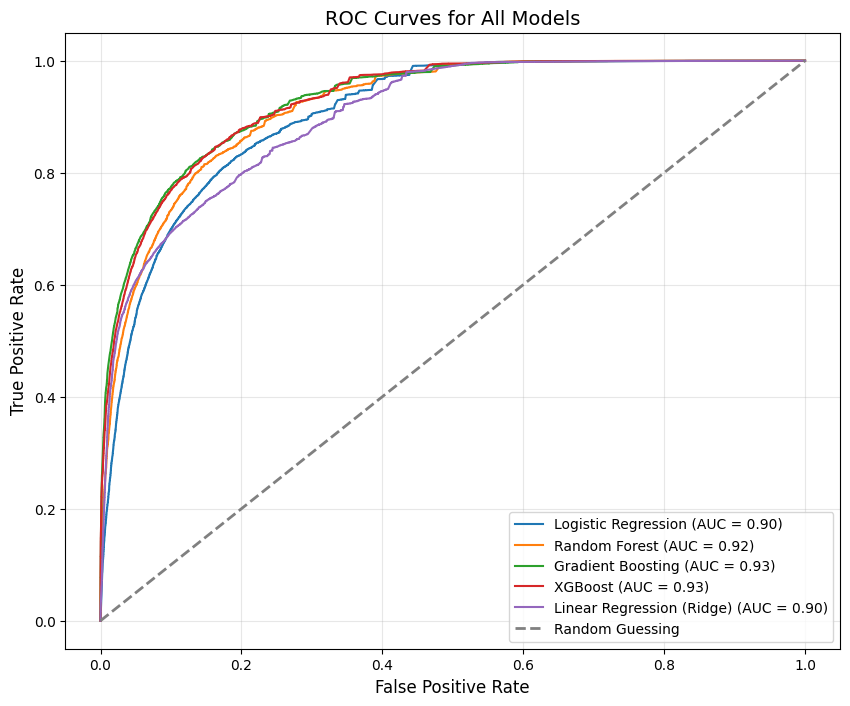

In [32]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
for model_name, (fpr, tpr) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_scores[model_name]:.2f})")

# Add baseline and labels
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label="Random Guessing")
plt.title("ROC Curves for All Models", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


## Model explanation

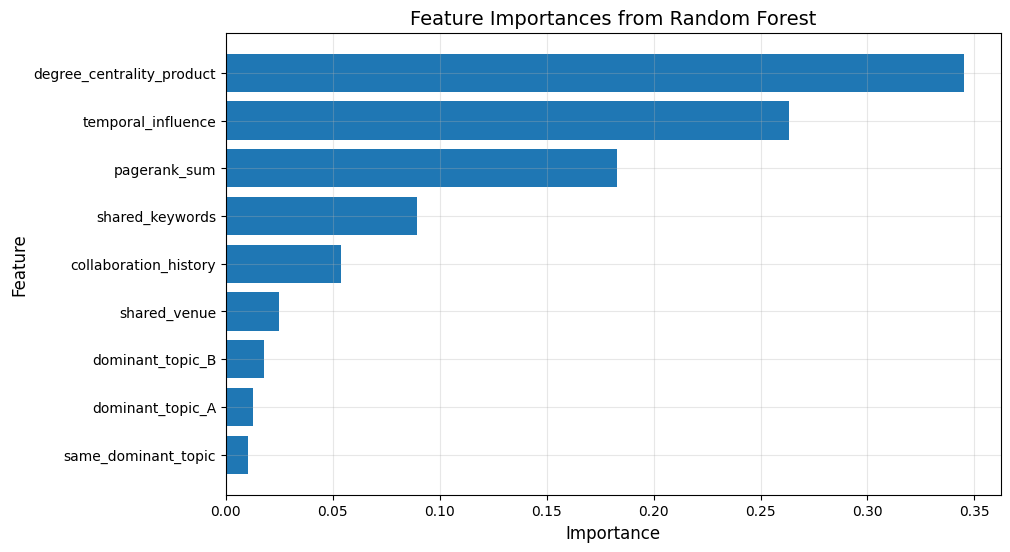

In [53]:

feature_importances = best_models['Random Forest'].feature_importances_
features = X_train.columns

# Sort the features by importance
feature_importances, features = zip(*sorted(zip(feature_importances, features)))


# plot this
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importances from Random Forest', fontsize=14)
plt.grid(alpha=0.3)
plt.show()


In [ ]:
# Initialize SHAP Explainers
explainers = {
    'Gradient Boosting': shap.TreeExplainer(best_models['Gradient Boosting']),
    'XGBoost': shap.TreeExplainer(best_models['XGBoost']),
}

# Compute SHAP values for each model
shap_values = {
    model_name: explainer.shap_values(X_test)
    for model_name, explainer in explainers.items()
}

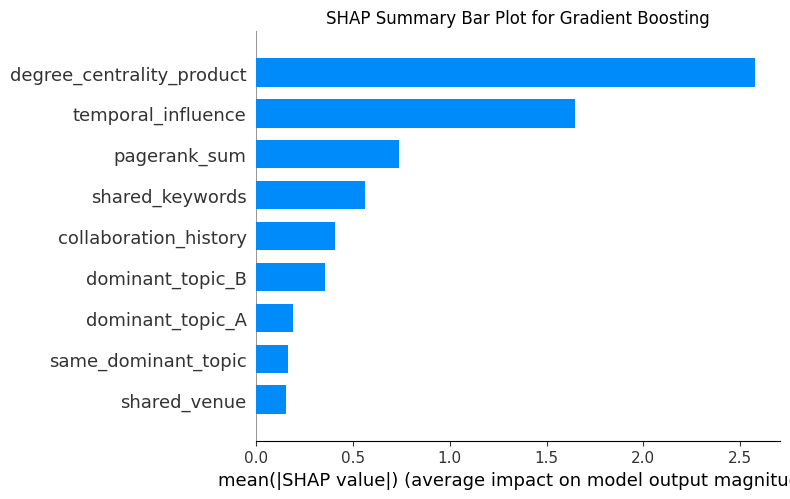

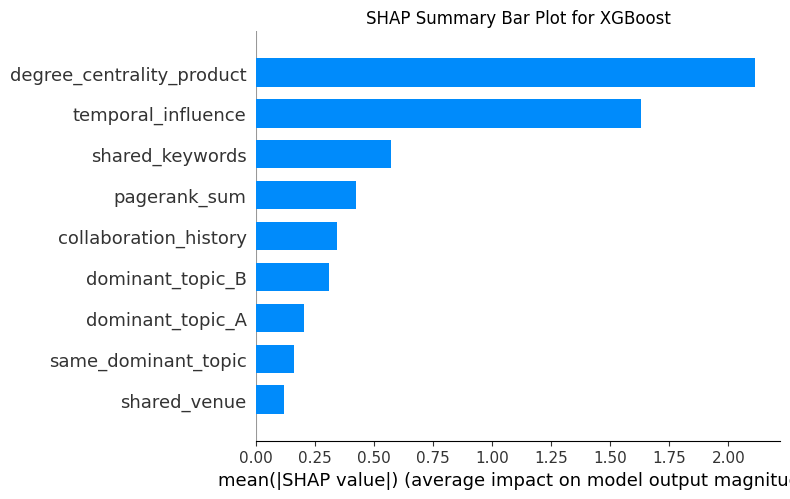

In [48]:
# Plot SHAP summary plots
for model_name, shap_vals in shap_values.items():
    plt.title(f'SHAP Summary Bar Plot for {model_name}')
    shap.summary_plot(shap_vals, X_test, plot_type='bar')
    plt.show()

# # Plot SHAP dependence plots
# for model_name, shap_vals in shap_values.items():
#     for feature in features:
#         shap.dependence_plot(feature, shap_vals, X_test, title=f'SHAP Dependence Plot for {model_name}')

# # Plot SHAP force plots
# for model_name, shap_vals in shap_values.items():
#     for i in range(5):
#         plt.title(f'SHAP Force Plot for {model_name}')
#         shap.force_plot(explainers[model_name].expected_value, shap_vals[i, :], X_test.iloc[i, :])
#         plt.show()


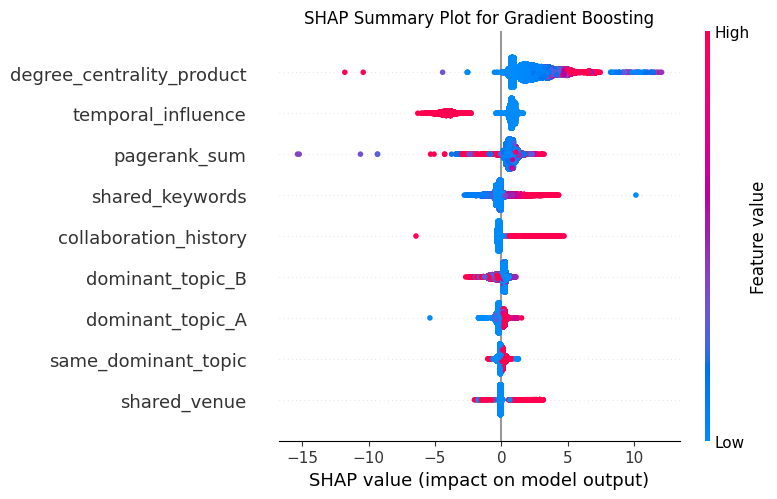

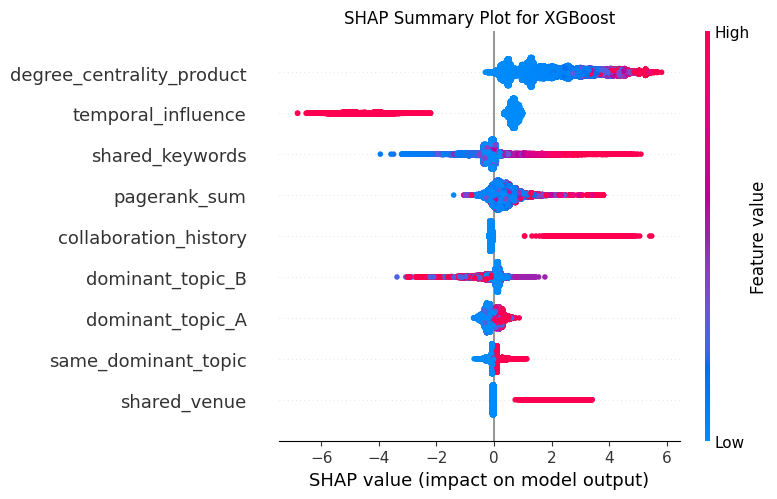

In [49]:
# Plot SHAP summary plots
for model_name, shap_vals in shap_values.items():
    plt.title(f'SHAP Summary Plot for {model_name}')
    shap.summary_plot(shap_vals, X_test)